In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from ipynb.fs.defs.ImportDB import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_twoyears.csv', low_memory=False)

In [3]:
len(df)

198

In [6]:
class Stat_Test:
    
    def __init__(self, ad_measure, vis_outcome):
        self.ad_measure = ad_measure
        self.vis_outcome = vis_outcome
    
    def measures_print(self):
        print("The adherence measure is {}, and the visual outcome is {}.".format(self.ad_measure, self.vis_outcome))
        
    def median(self):
        median = np.median(df[self.ad_measure])
        return median
        
    def samples(self):
        median = np.median(df[self.ad_measure])
        early = df[df[self.ad_measure] < median]
        late = df[df[self.ad_measure] >= median]
        sample_1 = early[self.vis_outcome]
        sample_2 = late[self.vis_outcome]
        return sample_1, sample_2, median
    
    def t_test_ind(self):
        sample_1, sample_2, median = self.samples()
        t, pval = stats.ttest_ind(sample_1, sample_2)
        return t, pval
        
    def mann_whitney(self):
        sample_1, sample_2, median = self.samples()
        t, pval = stats.mannwhitneyu(sample_1, sample_2)
        return t, pval
            
    def all_tests(self):
        t_1, p_1 = self.t_test_ind()
        t_2, p_2 = self.mann_whitney()
        sample_1, sample_2, cutoff = self.samples()
        median = np.round(cutoff, 2)
        x_1, x_2 = np.mean(sample_1), np.mean(sample_2)
        print("Those in Group 1 had adherence measure less than {}, and those in Group 2 had adherence measure greater than {}.".format(median, median))
        print("The mean for Early is {} and the mean for Late is {}.".format(np.round(x_1, 2), np.round(x_2, 2)))
        print("The test statistic for the independent t-test is {} and the p-value is {}.".format(np.round(t_1, 3), 
                                                                                                     np.round(p_1, 5)))
        print("The test statistic for the parametric t-test is {} and the p-value is {}.".format(np.round(t_2, 3), 
                                                                                                     np.round(p_2, 5)))
        if p_1 < 0.05 and p_2 > 0.05:
            print("The independent t-test returned a significant result whilst the parametric t-test did not.")
        elif p_1 > 0.05 and p_2 < 0.05:
            print("The parametric t-test returned a significant result whilst the independent t-test did not.")
        elif p_1 < 0.05 and p_2 < 0.05:
            print("Both tests returned a significant result.")
        else:
            print("Neither test returned a significant result. It is likely these are the same distribution.")
            
    # rotating samples function
    def samples_search(self):
        minimum = np.round(df[self.ad_measure].min(), 2)
        maximum = np.round(df[self.ad_measure].max(), 2)
        data_range = np.linspace(minimum, maximum, 100)
        diff, cut_point, len_s1, len_s2, mean_1, mean_2, p_value = 0, 0, 0, 0, 0, 0, 100
        for i in range(len(data_range)):
            cutoff = data_range[i]
            early = df[df[self.ad_measure] < cutoff]
            late = df[df[self.ad_measure] >= cutoff]
            if len(early) != 0 and len(late) != 0:
                sample_1, sample_2 = early[self.vis_outcome], late[self.vis_outcome]
                x_1, x_2 = np.mean(sample_1), np.mean(sample_2)
                t, pval = self.mann_whitney()
                if pval < 0.05 and abs(x_1 - x_2) > diff and len(sample_1) > 50 and len(sample_2) > 50:
                    difference = abs(x_1 - x_2)
                    diff = np.round(difference, 4)
                    mean_1, mean_2 = np.round(x_1, 2), np.round(x_2, 2)
                    cut_point = np.round(cutoff, 4)
                    len_s1, len_s2 = len(sample_1), len(sample_2)
                    p_value = np.round(pval, 5)
                    i += 1
                else: 
                    i += 1
        return diff, cut_point, len_s1, len_s2, mean_1, mean_2, p_value

    def confidence_interval(self, sample_1, sample_2):
        cm = sms.CompareMeans(sms.DescrStatsW(sample_1), sms.DescrStatsW(sample_2))
        conf_int = cm.tconfint_diff(usevar='unequal')
        return conf_int
    
    def samples_ci(self, cut):
        early = df[df[self.ad_measure] < cut]
        late = df[df[self.ad_measure] >= cut]
        sample_1 = early[self.vis_outcome]
        sample_2 = late[self.vis_outcome]
        return sample_1, sample_2

    
    # print results from sample_search
    def print_samples_search(self):
        diff, cut_point, len_s1, len_s2, mean_1, mean_2, p_value = self.samples_search()
        sample_1, sample_2 = self.samples_ci(cut_point)
        ci = self.confidence_interval(sample_1,sample_2)
        if diff > 0:
            print("Adherence measure: {}".format(self.ad_measure))
            print("The cutoff point which maximised the difference in visual outcome between the groups is {}.".format(cut_point))
            print("This gave a p-value of {}, with {} people in the EARLY GROUP and {} people in the LATE GROUP.".format(p_value, len_s1, len_s2))
            print("The early group had mean {} of {}, and the late group had mean {} of {}.".format(self.vis_outcome, mean_1, self.vis_outcome, mean_2))
            print("Thus, the maximum difference in {} between the two groups (that maintained significance) was {}.".format(self.vis_outcome, diff))
            print("This gave a confidence interval of {}.".format(ci))
        else:
            sample_1, sample_2, median = self.samples()
            t, pval = self.mann_whitney()
            print("There was no cutoff point for {} that found a significant difference in {}.".format(self.ad_measure, self.vis_outcome))
            print("P-value: {}. Median: {}. Mean1, Mean2: {}, {}".format(pval, median, np.mean(sample_1), np.mean(sample_2)))

In [6]:
class Results:
    
    def __init__(self, initiation=False):
        self.initiation = initiation
    
    def get_df(self):
        """
        Returns the appropriate dataframe (initiation or whole).
        """
        if self.initiation == False:
            df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_dataframe.csv', 
                             low_memory=False)
        else:
            df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_initiation.csv', 
                             low_memory=False)
    
    def all_cutoff_points_print(self):
        ad_measures = ['mean_adherence', 'adherence_variation',
           'percentage_late', 'percentage_early', 'MAFL', 'MAFE']
        vis_outcomes = ['mean_vision', 'proportion_above_baseline',
           'peak_visual_improvement', 'loss_from_peak', 'time_to_peak']
        for i in range(len(ad_measures)):
            for j in range(len(vis_outcomes)):
                p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
                p1.print_samples_search()
                print("       ")
                
    def all_combinations():
        results = pd.DataFrame(columns = ['mean_adherence', 'adherence_variation',
           'percentage_late', 'MAFL', 'MAFE'], index = ['mean_vision',
           'time_above_baseline_1year', 'time_above_baseline_2year',
           'time_above_baseline_4year', 'proportion_above_baseline',
           'peak_visual_improvement', 'loss_from_peak', 'time_to_peak'])
        ad_measures = ['mean_adherence', 'adherence_variation',
           'percentage_late', 'MAFL', 'MAFE']
        vis_outcomes = ['mean_vision',
           'time_above_baseline_1year', 'time_above_baseline_2year',
           'time_above_baseline_4year', 'proportion_above_baseline',
           'peak_visual_improvement', 'loss_from_peak', 'time_to_peak']
        for i in range(len(ad_measures)):
            for j in range(len(vis_outcomes)):
                p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
                t, pval = p1.t_test_ind()
                results[ad_measures[i]][vis_outcomes[j]] = pval
        return results

In [20]:
def all_combinations():
    results = pd.DataFrame(columns = ['mean_adherence', 'adherence_variation',
       'percentage_late', 'MAFL', 'MAFE'], index = ['mean_vision',
       'time_above_baseline_1year', 'time_above_baseline_2year',
       'time_above_baseline_4year', 'proportion_above_baseline',
       'peak_visual_improvement', 'loss_from_peak', 'time_to_peak'])
    ad_measures = ['mean_adherence', 'adherence_variation',
       'percentage_late', 'MAFL', 'MAFE']
    vis_outcomes = ['mean_vision',
       'time_above_baseline_1year', 'time_above_baseline_2year',
       'time_above_baseline_4year', 'proportion_above_baseline',
       'peak_visual_improvement', 'loss_from_peak', 'time_to_peak']
    for i in range(len(ad_measures)):
        for j in range(len(vis_outcomes)):
            p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
            t, pval = p1.t_test_ind()
            results[ad_measures[i]][vis_outcomes[j]] = pval
    return results

In [15]:
p1 = Stat_Test("percentage_late", "loss_from_peak")
p1.all_tests()

Those in Group 1 had adherence measure less than 0.2, and those in Group 2 had adherence measure greater than 0.2.
The mean for Early is 0.18 and the mean for Late is 0.2.
The test statistic for the independent t-test is -1.442 and the p-value is 0.15019.
The test statistic for the parametric t-test is 12289.0 and the p-value is 0.07541.
Neither test returned a significant result. It is likely these are the same distribution.


In [4]:
df.columns

Index(['Unnamed: 0', 'mean_adherence', 'adherence_variation',
       'percentage_late', 'percentage_early', 'MAFL', 'MAFE',
       'adherence_year1', 'adherence_year2', 'mean_vision',
       'time_above_baseline', 'peak_visual_improvement',
       'overall_visual_change', 'time_to_peak', 'baseline', 'gender', 'age',
       'visits', 'ID'],
      dtype='object')

In [7]:
def all_cutoff_points_print():
    ad_measures = ['mean_adherence', 'adherence_variation',
       'percentage_late', 'percentage_early', 'MAFL', 'MAFE', 'adherence_year1', 'adherence_year2']
    vis_outcomes = ['mean_vision', 'peak_visual_improvement', 'time_above_baseline', 'overall_visual_change', 'time_to_peak']
    for i in range(len(ad_measures)):
        for j in range(len(vis_outcomes)):
            p1 = Stat_Test(ad_measures[i], vis_outcomes[j])
            p1.print_samples_search()
            print("       ")
            
all_cutoff_points_print()

Adherence measure: mean_adherence
The cutoff point which maximised the difference in visual outcome between the groups is 1.0032.
This gave a p-value of 0.0197, with 92 people in the EARLY GROUP and 106 people in the LATE GROUP.
The early group had mean mean_vision of 57.08, and the late group had mean mean_vision of 47.89.
Thus, the maximum difference in mean_vision between the two groups (that maintained significance) was 9.1903.
This gave a confidence interval of (1.4957970663835098, 16.884705804822367).
       
There was no cutoff point for mean_adherence that found a significant difference in peak_visual_improvement.
P-value: 0.44793430983174304. Median: 1.0068. Mean1, Mean2: 20.259255555555555, 20.16161717171717
       
There was no cutoff point for mean_adherence that found a significant difference in time_above_baseline.
P-value: 0.2920826316066551. Median: 1.0068. Mean1, Mean2: 251.34343434343435, 221.25252525252526
       
There was no cutoff point for mean_adherence that fou

# Starting vision

In [13]:
df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_twoyears.csv')

In [14]:
np.median(df['baseline'])

0.5

In [15]:
df_low = df[df['baseline'] < 0.30]
df_high = df[df['baseline'] >= 0.30]

In [196]:
visual_outcomes = ['peak_visual_improvement', 'overall_visual_change', 'time_above_baseline']
for outcome in visual_outcomes:
    print("For the low baseliners, the mean {} was {}.".format(outcome, np.mean(df_low[outcome])))
    print("For the high baseliners, the mean {} was {}.".format(outcome, np.mean(df_high[outcome])))
    print(" ")
    
print("There were {} in the low baseliners group, and {} in the high baseliners group.".format(len(df_low), len(df_high)))

For the low baseliners, the mean peak_visual_improvement was 22.017237931034483.
For the high baseliners, the mean peak_visual_improvement was 19.46190428571428.
 
For the low baseliners, the mean overall_visual_change was 8.546939655172412.
For the high baseliners, the mean overall_visual_change was -0.5047607142857146.
 
For the low baseliners, the mean time_above_baseline was 293.2586206896552.
For the high baseliners, the mean time_above_baseline was 212.7.
 
There were 58 in the low baseliners group, and 140 in the high baseliners group.


In [50]:
len(df_low), len(df_high)

(140, 330)

In [23]:
from scipy.stats import spearmanr

In [199]:
corr, _ = spearmanr(df['baseline'], df['time_above_baseline'])
corr

-0.33455009667561675

In [18]:
sample_1 = df_low.time_above_baseline
sample_2 = df_high.time_above_baseline
stats.mannwhitneyu(sample_1, sample_2)

MannwhitneyuResult(statistic=3380.0, pvalue=0.02898146322848768)

# Improvement

In [7]:
df_stag = df[df['peak_visual_improvement'] == 0]
df_imp = df[df['peak_visual_improvement'] > 0]

In [8]:
len(df_stag)

71

In [9]:
len(df_imp)

127

In [10]:
visual_outcomes = ['peak_visual_improvement', 'overall_visual_change', 'time_above_baseline']
for outcome in visual_outcomes:
    print("For the stags, the mean {} was {}.".format(outcome, np.mean(df_stag[outcome])))
    print("For the imps, the mean {} was {}.".format(outcome, np.mean(df_imp[outcome])))
    print(" ")

For the stags, the mean peak_visual_improvement was 0.0.
For the imps, the mean peak_visual_improvement was 31.509184251968495.
 
For the stags, the mean overall_visual_change was -13.442876056338028.
For the imps, the mean overall_visual_change was 10.862206299212597.
 
For the stags, the mean time_above_baseline was 0.0.
For the imps, the mean time_above_baseline was 368.40157480314963.
 


In [10]:
min(df_imp.time_above_baseline.to_list())

21

In [12]:
sample_1 = df_stag.time_above_baseline
sample_2 = df_imp.time_above_baseline
stats.mannwhitneyu(sample_1, sample_2)

MannwhitneyuResult(statistic=0.0, pvalue=3.821303119800761e-33)

## Time to peak

In [14]:
np.median(df.time_to_peak)

208.5

In [18]:
fast = df[df.time_to_peak <= 208]
slow = df[df.time_to_peak > 208]

In [20]:
visual_outcomes = ['peak_visual_improvement', 'overall_visual_change', 'time_above_baseline']
for outcome in visual_outcomes:
    print("For the fast, the mean {} was {}.".format(outcome, np.mean(fast[outcome])))
    print("For the slow, the mean {} was {}.".format(outcome, np.mean(slow[outcome])))
    print(" ")

For the fast, the mean peak_visual_improvement was 9.893938383838384.
For the slow, the mean peak_visual_improvement was 30.526934343434327.
 
For the fast, the mean overall_visual_change was -6.548817171717169.
For the slow, the mean overall_visual_change was 10.842312121212123.
 
For the fast, the mean time_above_baseline was 118.8989898989899.
For the slow, the mean time_above_baseline was 353.6969696969697.
 


In [24]:
sample_1 = fast.time_above_baseline
sample_2 = slow.time_above_baseline
stats.mannwhitneyu(sample_1, sample_2)

MannwhitneyuResult(statistic=2069.0, pvalue=3.2404780423777856e-13)

In [21]:
len(fast), len(slow)

(99, 99)

# Random forest

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from fastai.tabular.all import *
from IPython.display import Image, display_svg, SVG
from sklearn import metrics, datasets, ensemble
from fastbook import *

In [147]:
df = pd.read_csv('/home/jupyter/charliemacuject/research_papers/data/adherence_twoyears.csv', low_memory=False)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

In [148]:
dep_var = 'mean_vision'

In [149]:
y = np.log(df[dep_var])

In [150]:
df.columns

Index(['mean_adherence', 'adherence_variation', 'percentage_late',
       'percentage_early', 'MAFL', 'MAFE', 'adherence_year1',
       'adherence_year2', 'mean_vision', 'time_above_baseline',
       'peak_visual_improvement', 'overall_visual_change', 'baseline',
       'gender', 'age', 'visits', 'ID'],
      dtype='object')

In [151]:
X = df.drop(columns=['mean_vision', 'gender', 'time_above_baseline',
       'peak_visual_improvement', 'overall_visual_change', 'ID', 'baseline'])

In [152]:
xs, valid_xs, y, valid_y = train_test_split(X, y, test_size=0.15, random_state=42)

In [153]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

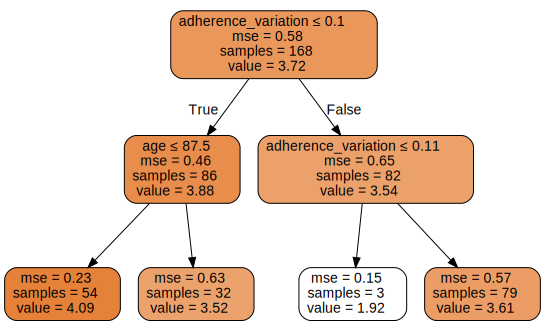

In [154]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

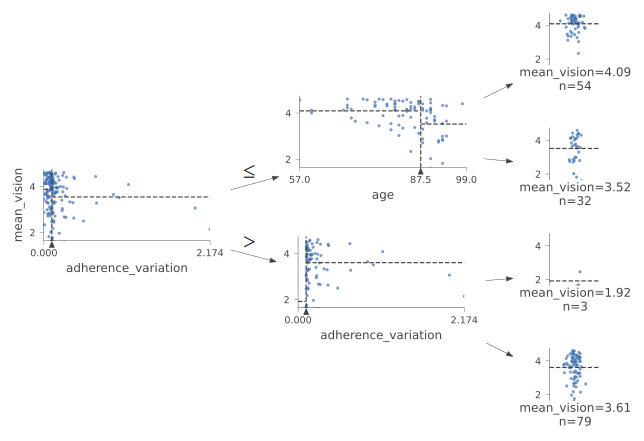

In [155]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [156]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [157]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [158]:
m_rmse(m, xs, y)

0.0

In [159]:
m_rmse(m, valid_xs, valid_y)

0.730803

In [160]:
m.get_n_leaves(), len(xs)

(167, 168)

In [161]:
m = DecisionTreeRegressor(min_samples_leaf=10)
m.fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.610345, 0.856027)

In [162]:
m.get_n_leaves()

13

In [163]:
def rf(xs, y, n_estimators=40, max_samples=168,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [164]:
m = rf(xs, y);

In [165]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.55819, 0.649358)

In [166]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [167]:
r_mse(preds.mean(0), valid_y)

0.649358

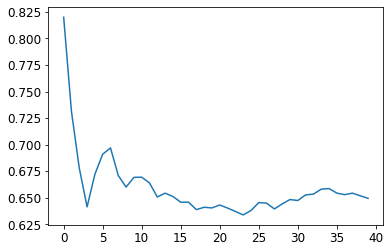

In [168]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [169]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [170]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
1,adherence_variation,0.119670
9,visits,0.113861
6,adherence_year1,0.112956
8,age,0.111741
4,MAFL,0.100326
3,percentage_early,0.098352
0,mean_adherence,0.094378
7,adherence_year2,0.092993
5,MAFE,0.089962
2,percentage_late,0.065762


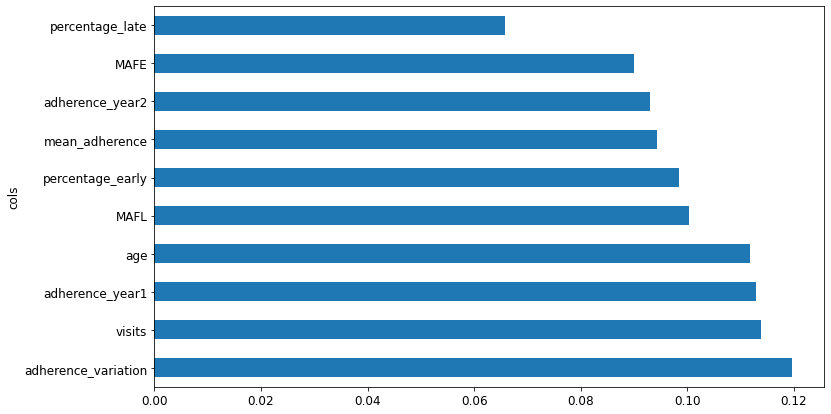

In [171]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:10]);